In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import mpld3
import pandas as pd
import imp
import folium
import numpy as np
from sqlalchemy import create_engine
sn.set_context('notebook')

# RID project: initial data exploration

Tore coded his previous analyses for the RID project using PL/SQL within the RESA2 database. Some changes are required this year, so I either need to figure out how to update and run Tore's old code, or I need to re-code a new workflow that will be compatible with what has been done previously. This notebook documents my initial exploration of the data and the tables within the NIVA database.

## 1. Sites of interest

A copy of the 2015 report (produced during 2016) is here:

C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\Report\RID REPORT 2015_1 DEC 2016_final.pdf

According to this, the RID programme includes 11 sites that are monitored at monthly frequency or higher, 36 (actually 37 - see below) sites monitored quarterly, and 108 sites that are no longer monitored at all, but which have data prior to 2004. After a bit of exploration in RESA2, it looks as though the key projects are as follows:

• The RID_11 sites are under project **`RID (O 25800 03)`**

• The RID_36 sites (actually 37 of them) are under project **`RID - Bielver (O 25800 04)`**

• The RID_108 sites are under project **`RID - 109`**

I've extracted basic metadata for the sites in these three projects here:

C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\Data\RID_Sites_List.xlsx

Note that one of the 37 sites in the RID_36 project is missing an NVE "vassdragnummer", which might explain why it is not usually included?

In the raw station data, there are 7 sites missing geographic (lat/lon) co-ordinates and one missing projected (UTM) co-ordinates. As a first step, I've made some basic co-ordinate conversions and added this metadata to the `STATIONS` table in RESA2.

The code below reads the metadata and creates a simple interactive map. **Use the "layer control" top-right to turn groups of sites on and off, and click on a site to see the station name and code**.

In [2]:
# Read site data
in_xlsx = r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\Data\RID_Sites_List.xlsx'

rid_11_df = pd.read_excel(in_xlsx, sheetname='RID_11')
rid_36_df = pd.read_excel(in_xlsx, sheetname='RID_36')
rid_108_df = pd.read_excel(in_xlsx, sheetname='RID_108')

# Drop the 37th site (with no NVE code) from RID_36
rid_36_df.dropna(how='any', inplace=True)

In [3]:
# Setup map
map1 = folium.Map(location=[65, 10.8],
                  zoom_start=4,
                  tiles='Stamen Terrain')

# Create feature groups
fg_11 = folium.FeatureGroup(name='RID 11')
fg_36 = folium.FeatureGroup(name='RID 36')
fg_108 = folium.FeatureGroup(name='RID 108')
fgs = [fg_11, fg_36, fg_108]

# Define colours
cols = ['red', 'green', 'blue']

# Add clickable markers for sites
for df_idx, df in enumerate([rid_11_df, rid_36_df, rid_108_df]):
    for idx, row in df.iterrows():  
        folium.Marker([row['lat'], row['lon']], 
                      popup='%s (%s)' % (row['station_name'], 
                                         row['station_code']),
                      icon=folium.Icon(color=cols[df_idx])).add_to(fgs[df_idx])

    # Add feature group to map
    map1.add_child(fgs[df_idx])

# Turn on layer control
map1.add_child(folium.map.LayerControl())

map1

## 2. Site data

For each of the stations identified above, we need to access two types of data: water chemistry and discharge. The NVE discharge datasets are stored in separate tables within RESA2 (`RESA2.DISCHARGE_STATIONS` and `RESA2.DISCHARGE_VALUES`), and the table `RESA2.DEFAULT_DIS_STATIONS` links the site IDs for the water chemistry stations to those for discharge.

The workflow for estimating loads should therefore look something like this:

 1. Write a function to extract water chemistry time series for a specified site, parameter(s) and time period <br><br>
 
 2. Write a function to identify the NVE discharge station associated with a specified water chemistry station and extract the discharge values for the desired time period <br><br>
 
 3. Calculate loads using the methodology defined by OSPAR
 
These steps are considered in turn below. The first step is to establish a connection to the database.

In [4]:
# Connect to db
resa2_basic_path = (r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\Upload_Template'
                    r'\useful_resa2_code.py')

resa2_basic = imp.load_source('useful_resa2_code', resa2_basic_path)

engine, conn = resa2_basic.connect_to_resa2()

### 2.1. Extract water chemistry data

For the ICP Waters project, I have previously written code to extract data from RESA2. For the RID project, I have modified these functions and transferred them to a new file, which can be found [here](https://github.com/JamesSample/rid/blob/master/notebooks/useful_rid_code.py)

In [5]:
# Import custom RID functions
rid_func_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
                 r'\Python\rid\notebooks\useful_rid_code.py')

rid = imp.load_source('useful_rid_code', rid_func_path)

The function `extract_water_chem` provides a reasonably flexible method for extracting and plotting water chemistry data. The example below produces an interactive plot showing time series from 2010 to 2015 for six parameters at Vesenum, which is one of the sites within the RID programme. **Hovering the mouse over the plot should display pan and zoom tools towards the bottom-left corner - use these to explore the data**.

Note that the code also checks for duplicates in the database and prints a warning if multiple values are found for the same site-date-parameter combination. This seems to happen quite frequently in RESA2, perhaps due to samples being re-analysed? My code **preferentially selects the values added to the database most recently** and discards the others. To facilitate checking, all the duplicates are returned in the dataframe `dup_df`, which can be inspected to make sure everything looks OK.

In [6]:
# Station of interest
stn_id = 29617

# Pars of interest
par_list = ['pH', 'KOND', 'TOC', 'TOTN', 'TOTP', 'Hg']

# Get data between 2010 and 2015
wc_df, dup_df, fig = rid.extract_water_chem(stn_id, par_list, 
                                            '2010-01-01', '2015-12-31',
                                            engine, plot=True)

# Plot
mpld3.display(fig)

    WARNING
    The database contains duplicated values for some station-date-parameter combinations.
    Only the most recent values will be used, but you should check the repeated values are not errors.
    The duplicated entries are returned in a separate dataframe.



The function returns a dataframe of the extracted data, in the format illustrated below. In addition to getting the water chemistry values themselves, the function also retrieves limit of detection (LOD) flags, which are needed in the calculations below. For example, if the value in the `TOC_mg/l` column is $x$ and the entry in the `TOC_flag` column is `'<'`, this indiates a LOD value of less than $x \; mg/l$.

**Note:** On the plots returned by this function (e.g. above), any LOD values are plotted at the LOD.

In [7]:
# View chemistry data and LOD values
wc_df.head(10)

,Hg_ng/l,KOND_mS/m,TOC_mg C/l,TOTN_µg/l N,TOTP_µg/l P,pH_None,Hg_flag,KOND_flag,TOC_flag,TOTN_flag,TOTP_flag,pH_flag
sample_date,,,,,,,,,,,,
2010-01-04,1.0,4.57,3.5,535.0,5.0,6.98,<,None,None,None,None,None
2010-02-08,1.0,4.97,3.1,585.0,6.0,7.06,<,None,None,None,None,None
2010-03-08,1.0,4.79,3.0,560.0,5.0,7.23,<,None,None,None,None,None
2010-04-06,1.0,6.25,4.6,900.0,31.0,7.04,<,None,None,None,None,None
2010-05-10,1.0,4.73,6.0,610.0,17.0,7.16,<,None,None,None,None,None
2010-05-18,1.0,4.47,5.8,540.0,6.0,7.13,<,None,None,None,None,None
2010-05-25,1.0,3.81,5.9,510.0,26.0,6.99,<,None,None,None,None,None
2010-05-31,1.0,3.35,4.5,430.0,15.0,7.05,<,None,None,None,None,None
2010-06-07,1.0,3.97,3.7,395.0,10.0,7.28,<,None,None,None,None,None


In [8]:
# Display duplicates
dup_df.head(10)

,station_code,sample_date,name,unit,value,flag1,entered_date_x
245,ØSTEGLO,2012-06-14 00:00:00,Hg,ng/l,1.0,<,2012-08-13 14:59:50
246,ØSTEGLO,2012-06-14 00:00:00,Hg,ng/l,1.0,<,2012-08-08 14:58:43
258,ØSTEGLO,2012-07-09 00:00:00,Hg,ng/l,2.0,None,2012-10-02 00:04:19
259,ØSTEGLO,2012-07-09 00:00:00,Hg,ng/l,2.0,None,2012-09-03 08:29:56
379,ØSTEGLO,2013-09-02 13:30:00,Hg,ng/l,2.0,None,2013-11-09 00:01:40
380,ØSTEGLO,2013-09-02 13:30:00,Hg,ng/l,2.0,None,2013-09-29 00:01:49
446,ØSTEGLO,2014-06-04 16:30:00,Hg,ng/l,1.0,<,2015-01-17 00:02:23
447,ØSTEGLO,2014-06-04 16:30:00,Hg,ng/l,1.0,<,2014-07-02 00:02:35
453,ØSTEGLO,2014-06-12 16:30:00,Hg,ng/l,1.0,<,2014-10-23 09:45:00
454,ØSTEGLO,2014-06-12 16:30:00,Hg,ng/l,1.0,<,2014-07-26 00:07:09


### 2.2. Extract discharge data

Similarly, the function `extract_discharge` provides options for extracting and plotting NVE flow data for a specified water chemistry site. The function automatically identifies the correct NVE station for the RID site specified, and discharge values are scaled by the ratio of catchment areas. Any missing values in the series are **linearly interpolated**.

As above, **hovering the mouse over the plot should display pan and zoom tools towards the bottom-left corner - use these to explore the data**.

In [9]:
# Get data between 2010 and 2015
q_df, fig = rid.extract_discharge(stn_id, 
                                  '2010-01-01', '2015-12-31',
                                   engine, plot=True)

# Plot
mpld3.display()

In [10]:
q_df.head()

,flow_m3/s
date,
2010-01-01,628.441710
2010-01-02,627.399518
2010-01-03,627.399518
2010-01-04,627.399518
2010-01-05,627.399518


### 2.3. Calculate loads

#### 2.3.1. Equation for load estimation

The method used for calculating loads is described in Section 2.2.4 and Appendix IV (page 110) of the RID report (see link above). It's a simple ratio estimator designed to allow for irregular (i.e. unevenly spaced) sampling.

$$Load = Q_r \frac{\sum_{i=1}^n Q_i C_i t_i}{\sum_{i=1}^n Q_i t_i}$$

where $Q_i$ represents the water discharge on the day of sampling ($day_i$); $C_i$ is the measured concentration on $day_i$; $t_i$ is the time period from the midpoint between $day_{i-1}$ and $day_i$ to the midpoint between $day_i$ and $day_{i+1}$ (i.e. half the number of days between the previous and next sampling); and $Q_r$ is the annual water volume.

Note that the formula is used only ***within one year*** i.e. the time period for the first sample runs from the start of the year to the midpoint between the first and second samples, whereas the time period for the last sample runs from the midpoint between $day_{n-1}$ and $day_n$ to the end of the year.

#### 2.3.2. Limit of detection values

In the current OSPAR methodology, LOD values are adjusted according to the proportion of values in the year that are at or below the LOD.

$$x_{adj} = \frac{x_{lod}(100 - p)}{100}$$

where $x_{lod}$ is the detection limit, $p$ is the percentage of measurements within the year at or below the LOD, and $x_{adj}$ is the adjusted value that is used in subsequent calculations. (See the procedure `CALCULATE_RID_STATISTICS` in RESA2 for Tore's implementation of this).

This simple formula reduces estimated concentrations linearly (from the detection limit to zero), according to how many of the year's other samples are also at or below the LOD. If all samples are below the LOD, the estimated concentrations are zero; if almost all samples are above the LOD, any LOD values that do occur are assumed to be very close to the detection limit itself.

#### 2.3.3. Load estimation code

To make load estimation easy, I've written a function that wraps the other two functions above (for chemistry and discharge) and then feeds the results into the equations above. This is fairly simple - the most complex part is estimating the time intervals, $t_i$. It's difficult to know whether I've taken the same approach as Tore here, but comparing the results from the two methods will hopefully provide some insight. For a single site, the loads function returns the following output for 2015.

**Note:** The `infer_missing` argument below is explained in a [later notebook]().

In [11]:
# Station of interest
stn_id = 29617

# Pars of interest
par_list = ['SPM', 'TOC', 'PO4-P', 'TOTP', 'NO3-N', 'NH4-N', 
            'TOTN', 'SiO2', 'Ag', 'As', 'Pb', 'Cd', 'Cu', 
            'Zn', 'Ni', 'Cr', 'Hg']

l_df = rid.estimate_loads(stn_id, par_list, 2015, 
                          engine, infer_missing=False)

l_df

,Ag_tonnes,As_tonnes,Cd_tonnes,Cr_tonnes,Cu_tonnes,Hg_kg,NH4-N_tonnes,NO3-N_tonnes,Ni_tonnes,PO4-P_tonnes,Pb_tonnes,SPM_tonnes,SiO2_tonnes,TOC_tonnes,TOTN_tonnes,TOTP_tonnes,Zn_tonnes
29617,0.091017,4.928401,0.306213,8.062688,40.647355,19.134369,411.81771,8622.401618,20.925368,282.264372,7.724925,285034.791838,103178.623738,115550.263032,15090.648727,485.957559,244.055539


## 3. Testing

The next step is to compare the results from my new method with those published in the 2015/16 report. A quick visual inspection of the output above suggests my values are similar - but not identical - to Tore's. In this section, I'd like to make a more comprehensive comparison for a broader range of sites.

First of all, I've copied the loads reported in 2015/16 for the RID_11 and RID_36 rivers to a spreadsheet here (data from pages 186 to 188 of the report):

C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet\Report\Loads_2015_RID11_RID36.xlsx

This will provide reference values against which my new approach can be compared. The RID_108 rivers have not been included, because they are not currently monitored, so the methodology developed above does not apply.

### 3.1. Read 2015 data

In [12]:
# Read output from previous years
in_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Report\Loads_2015_RID11_RID36.xlsx')
rid_36_old = pd.read_excel(in_xlsx, sheetname='RID_36')
rid_11_old = pd.read_excel(in_xlsx, sheetname='RID_11')

rid_11_old

,station_id,station_code,station_name,SPM_tonnes,TOC_tonnes,PO4-P_tonnes,TOTP_tonnes,NO3-N_tonnes,NH4-N_tonnes,TOTN_tonnes,SiO2_tonnes,Ag_tonnes,As_tonnes,Pb_tonnes,Cd_tonnes,Cu_tonnes,Zn_tonnes,Ni_tonnes,Cr_tonnes,Hg_kg
0,29617,ØSTEGLO,Glomma_ved_Sarpsfoss,295151,115805,291,499,8706,405,15182,103992,0.092,4.993,7.918,0.308,40.799,245.827,21.145,8.282,19.002
1,36225,OSLEALN,Alna,1228,280,4,5,47,7,83,424,0.000,0.025,0.120,0.005,0.288,1.186,0.070,0.042,0.060
2,29612,BUSEDRA,Drammenselva,75313,48045,80,140,2724,80,5378,39256,0.012,2.266,6.101,0.139,12.633,47.217,7.046,2.564,9.739
3,29615,VESENUM,Numedalslågen,36586,19767,30,54,809,107,1836,15401,0.027,0.858,1.286,0.061,3.332,14.104,1.678,0.757,6.887
4,29613,TELESKI,Skienselva,10151,32483,12,37,1322,99,2919,24128,0.004,1.223,0.933,0.098,4.699,32.443,2.024,0.848,10.562
5,29614,VAGEOTR,Otra,7186,18142,3,17,445,50,1354,9511,0.017,0.712,1.661,0.100,2.803,18.500,2.481,0.518,7.613
6,29783,ROGEORR,Orreelva,1864,1104,4,12,215,6,359,403,0.000,0.053,0.071,0.003,0.397,0.816,0.220,0.037,0.025
7,29821,HOREVOS,Vosso(Bolstadelvi),3883,4250,4,14,387,24,754,3884,0.002,0.306,0.313,0.023,1.330,4.631,1.375,0.227,4.520
8,29778,STREORK,Orkla,5924,5604,3,11,210,6,515,4289,0.000,0.201,0.080,0.060,7.050,20.050,1.390,0.477,1.543
9,29782,NOREVEF,Vefsna,11842,9734,6,18,197,11,716,8353,0.006,0.834,0.372,0.024,2.144,2.681,1.879,0.607,3.862


### 3.2. Run new code

I can now run my new code for all the stations in the RID_11 and RID_36 projects.

**Note:** Note, as mentioned above, the code highlights some duplicated values in the RESA2 database. For example, there were two Nitrate measurements associated with the same water sample at site 29819 on 07/05/2015 (using method IDs 10744 and 10699, respectively). The values for these two measurements are not the same and, based on the dates they were added to the database, it looks as though this water sample has been re-analysed. There are numerous other examples of this in RESA2, and the RESA2 application usually selects just one of the duplicates at random, which is undesirable. The code here keeps only the most recent (re-analysed?) value and ignores the duplicates, but **there is clearly a wider database issue to be addressed here**.

In [13]:
# Pars of interest
par_list = ['SPM', 'TOC', 'PO4-P', 'TOTP', 'NO3-N', 'NH4-N', 
            'TOTN', 'SiO2', 'Ag', 'As', 'Pb', 'Cd', 'Cu', 
            'Zn', 'Ni', 'Cr', 'Hg']

# Container for output
df_list = []

# Calculate loads for RID_11 and RID_36
# Loop over dfs
for df in [rid_11_df, rid_36_df]:
    # Container for results from each site
    loads_list = []
    
    # Loop over sites
    for stn_id in df['station_id'].values:
        # Estimate loads at this site
        loads_list.append(rid.estimate_loads(stn_id, par_list, 2015, 
                                             engine, infer_missing=False))
    
    # Concatenate to new df
    out_df = pd.concat(loads_list, axis=0)
       
    # Add to output
    df_list.append(out_df)

# Get new output for comparison
rid_11_new, rid_36_new = df_list   

rid_11_new

,Ag_tonnes,As_tonnes,Cd_tonnes,Cr_tonnes,Cu_tonnes,Hg_kg,NH4-N_tonnes,NO3-N_tonnes,Ni_tonnes,PO4-P_tonnes,Pb_tonnes,SPM_tonnes,SiO2_tonnes,TOC_tonnes,TOTN_tonnes,TOTP_tonnes,Zn_tonnes
29615,0.026935,0.857642,0.061187,0.748727,3.345883,7.112995,104.677253,791.020229,1.670895,29.548915,1.283444,36979.002284,15193.268316,19867.864209,1810.534032,53.897994,14.065115
29821,0.002379,0.305334,0.023144,0.217992,1.302675,3.978288,24.119539,372.603319,1.314200,3.633959,0.309924,3777.841986,3851.033678,4137.734303,733.010498,13.685448,4.635285
29783,0.000325,0.053566,0.002794,0.037010,0.404016,0.025647,5.706430,206.557392,0.219278,3.531852,0.070749,1867.622389,366.082323,1114.443010,349.411826,12.165597,0.832640
29613,0.004527,1.221973,0.097865,0.850659,4.698857,11.004514,99.503736,1318.560658,2.013014,11.300825,0.947345,10319.843195,24107.532086,32394.229840,2916.501627,37.401742,32.971022
29614,0.016655,0.700739,0.096378,0.505428,2.750329,6.967977,50.604554,439.577020,2.469154,2.015735,1.585930,7222.880842,9341.694816,17665.700424,1330.250807,16.437358,17.993453
29782,0.006552,0.836193,0.023915,0.607822,2.145138,3.906204,11.445259,194.449576,1.881794,6.497687,0.376671,11962.270724,8292.467660,9634.225217,707.992041,18.282458,2.698315
36225,0.000296,0.025437,0.004902,0.043385,0.293175,0.061423,6.596501,47.460809,0.070501,3.838184,0.124341,1269.805930,424.478777,280.182860,83.593775,4.607634,1.216439
29617,0.091017,4.928401,0.306213,8.062688,40.647355,19.134369,411.817710,8622.401618,20.925368,282.264372,7.724925,285034.791838,103178.623738,115550.263032,15090.648727,485.957559,244.055539
29779,0.002500,0.422303,0.004432,0.869318,1.500413,1.289895,11.676627,103.887959,0.923151,8.189500,0.061341,7899.952560,11033.754145,9977.875307,622.777057,20.269528,0.546425
29612,0.009394,2.284257,0.138656,2.594513,12.534268,9.981684,81.267971,2711.381499,7.087254,82.277626,6.127097,77060.904574,39139.162099,48220.003465,5386.225937,142.965548,47.804900


### 3.3. Comparison

We can now compare the results between the two analyses.

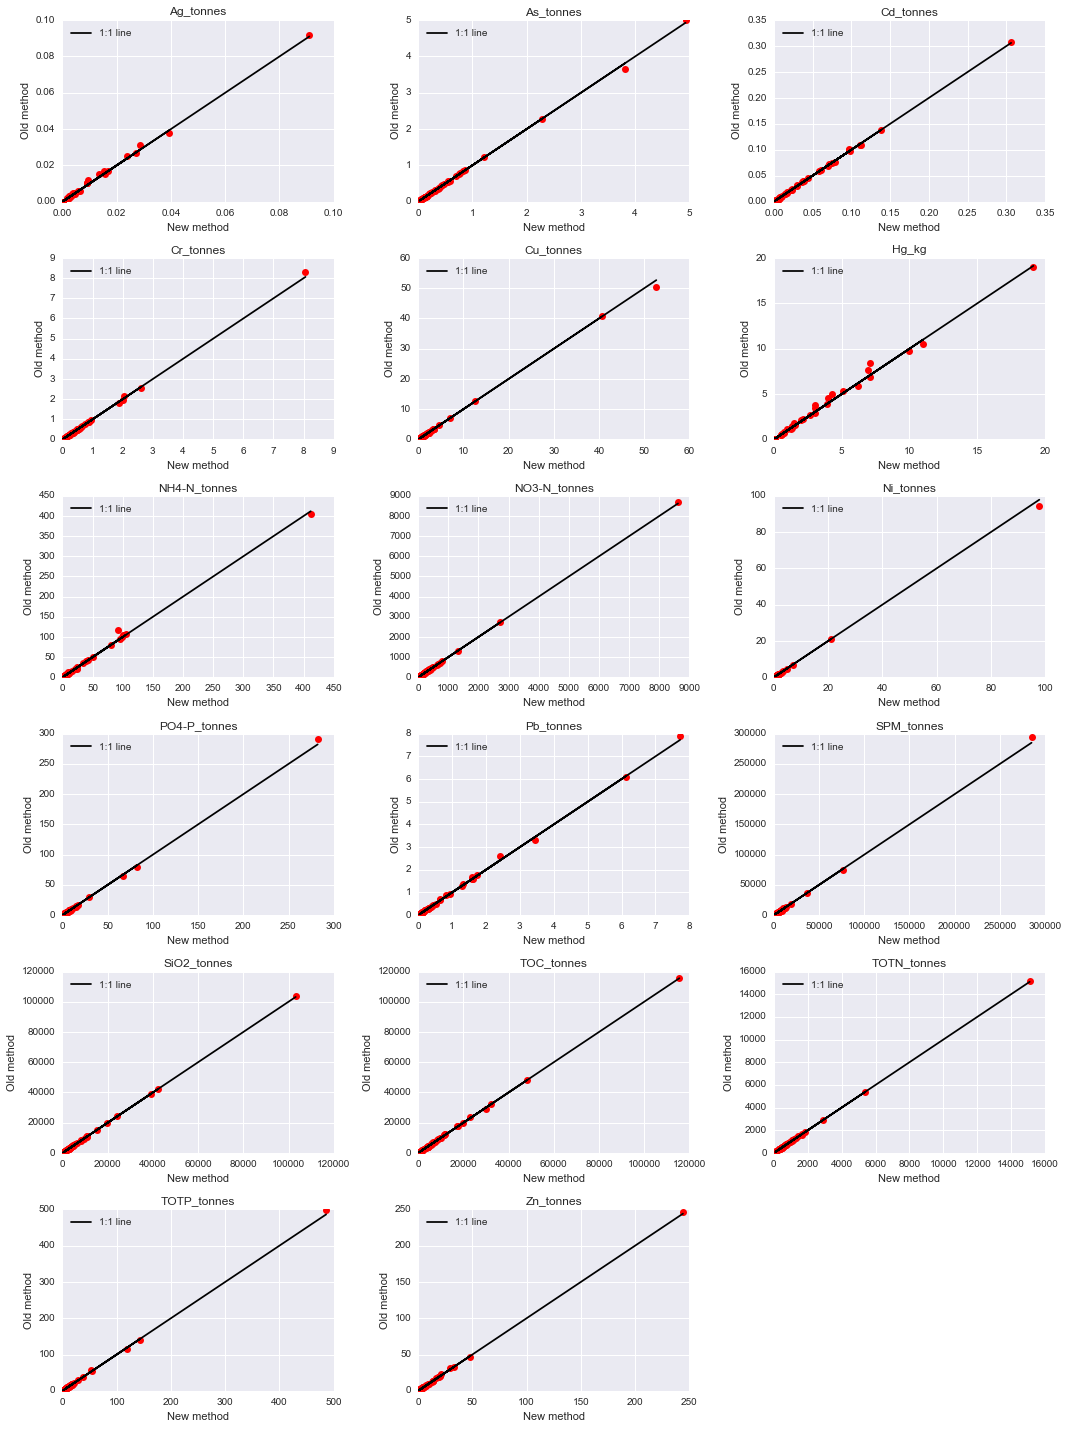

In [14]:
# Combine output from RID_11 and RID_36
old_df = pd.concat([rid_11_old, rid_36_old], axis=0)
new_df = pd.concat([rid_11_new, rid_36_new], axis=0)
old_df.index = old_df['station_id']

# Merge
df = pd.merge(old_df, new_df, how='left',
              left_index=True, right_index=True,
              suffixes=['_old', '_new'])

# Scatterplots
fig, axes = plt.subplots(nrows=6, ncols=3,
                         sharey=False, sharex=False,
                         figsize=(15,20))
axes = axes.flatten()

# Loop over plots
for idx, par in enumerate(new_df.columns):
    axes[idx].plot(df[par+'_new'], df[par+'_old'], 'ro', label='')
    axes[idx].plot(df[par+'_new'], df[par+'_new'], 'k-', label='1:1 line')
    axes[idx].set_xlabel('New method')
    axes[idx].set_ylabel('Old method')
    axes[idx].set_title(par)
    axes[idx].legend(loc='upper left')

# Tidy
fig.delaxes(axes[-1])
plt.tight_layout()

This looks pretty good to me - the results are virtually identical in all cases. 

Any remaining discrepancies seem so minor as to be negligible, and are probably easily explained by minor differences between my methodology and Tore's, or between the old and new discharge datasets supplied by NVE (old discharge values are sometimes retrospectively corrected, e.g. when ratings curves are improved). The most obvious - but still minor - outliers are on the NH4-N and Hg plots, and are most likely caused by me removing duplicates from the database, as mentioned above. **Check this**.